In [1]:
import os
import json
import time
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from scipy.spatial.distance import cdist
import gurobipy as gp
from gurobipy import GRB
from scipy.stats import skew
import math
import itertools
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error

# Load functions
from data_gen_functions import generate_tsp_instance, generate_cvrp_instance, fun_convert_time
from data_gen_functions import solve_tsp, solve_cvrp, plot_instance

# **Gurobi solver**

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-04
Total costs: 508.9672732818917
Optimal solution: [(0, 7), (7, 5), (5, 4), (4, 10), (10, 0), (0, 9), (9, 11), (11, 0), (0, 12), (12, 2), (2, 1), (1, 8), (8, 6), (6, 3), (3, 0)]


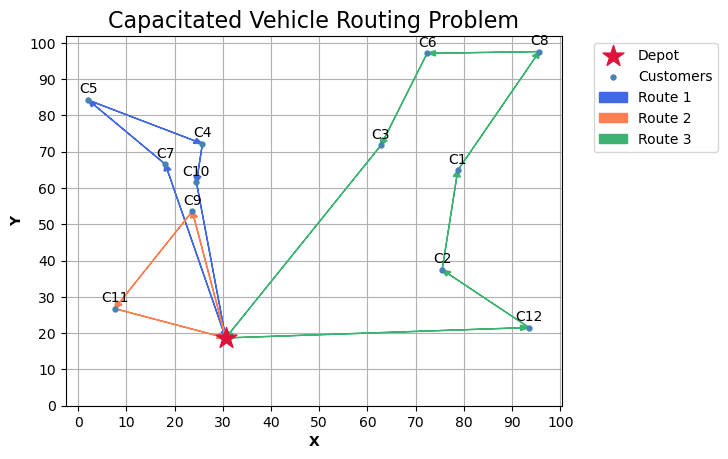

In [2]:
# Settings
num_customers = 12
x_range = (0, 100)
y_range = (0, 100)

routing_problem = 'CVRP'

if (routing_problem == 'TSP'):
    # Generate instance and extract the X and Y coordinates of depot and all customers
    instance_df = generate_tsp_instance(num_customers, x_range, y_range)
    coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]

    # Solve TSP and receive sequence (optimal tour) and total costs as output
    sequence, total_costs = solve_tsp(coordinates=coord)

elif (routing_problem == 'CVRP'):
    capacity_min = 10
    capacity_max = 18
    demand_min = 1
    demand_max = 5

    # Generate instance and extract the X and Y coordinates of depot and all customers as well as the demands and the capacity
    instance_df = generate_cvrp_instance(num_customers, x_range, y_range, demand_min, demand_max, capacity_min, capacity_max)
    coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]
    demands = list(instance_df['Demand'])
    capacity = instance_df.loc[0, 'Vehicle Capacity']

    # Solve TSP and receive sequence (optimal tour) and total costs as output
    sequence, total_costs = solve_cvrp(coordinates=coord, demands=demands, capacity=capacity)

# Plot TSP with optimal tour
plot_instance(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
              assignments=None, core_point_indices=None, plot_sequence=True, print_sequence=True, routing_problem=routing_problem)

# **PyVRP Solver**

Exact Total costs: 508.9672732818916 and Rounded Total Costs: 508.1
Optimal solution: [(0, 9), (9, 11), (11, 0), (0, 12), (12, 2), (2, 1), (1, 8), (8, 6), (6, 3), (3, 0), (0, 10), (10, 4), (4, 5), (5, 7), (7, 0)]


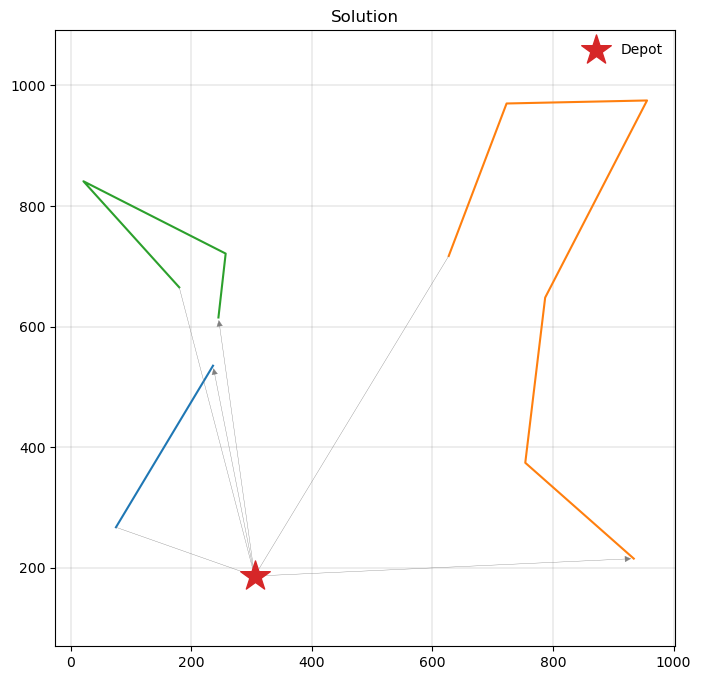

In [3]:
from tqdm import tqdm
import math
from tabulate import tabulate
from pyvrp import Model
import matplotlib.pyplot as plt
from pyvrp.plotting import plot_coordinates
from pyvrp.plotting import plot_solution
from pyvrp.stop import MaxRuntime

# Function to solve TSP and CVRP with PyVRP
def solve_PyVRP(coord, demands, capacity, max_runtime=1, constant=1000, plot_results=False, prints=False):

    # Multiply coordinates with a constant to get the true best solution since PyVRP uses only integers
    if (constant != 1): coord = [(i*constant, j*constant) for i, j in coord]

    # Create the model and define the number of vehicles
    m = Model()
    num_vehicles = math.ceil(np.sum(demands) / capacity) + 1

    # Add vehicles, the depot and the customers to the model
    m.add_vehicle_type(num_available=num_vehicles, capacity=capacity)
    depot = m.add_depot(x=coord[0][0], y=coord[0][1])
    clients = [m.add_client(x=coord[idx][0], y=coord[idx][1], delivery=demands[idx]) for idx in range(1, len(coord))]

    # Add the distances/edges between all the locations (depot and customers)
    locations = [depot] + clients
    for frm in locations:
        for to in locations:
            distance = np.sqrt((frm.x - to.x)**2 + (frm.y - to.y)**2) # Euclidean
            m.add_edge(frm, to, distance=distance)

    # Plot instance
    if (prints == True):
        _, ax = plt.subplots(figsize=(8, 8))
        plot_coordinates(m.data(), ax=ax)

    # Solve instance
    res = m.solve(stop=MaxRuntime(max_runtime), display=prints) # Define maximum run time (in seconds) for solving the instance
    
    # Get informations about the routes within the best solution and the rounded total costs of the best solution
    routes_details = res.best.routes()
    total_costs_rounded = res.cost() / constant # Devide by previously defined constant to get true distance

    data = [{'Number of Stops': len(route),
            'Customers': route.visits(),
            'Distance': route.distance(),
            'Delivery (Sum of Demands)': route.delivery()}
            for route in routes_details]

    # Display the information about the routes
    header = list(data[0].keys())
    rows = [datum.values() for datum in data]
    if (prints == True): display(tabulate(rows, header, tablefmt='html'))

    # Add the depot as start and end point to each route and convert it to the same format as the output of the Gurobi functions
    routes = [[0] + route['Customers'] + [0] for route in data] # e.g. routes = [[0, 2, 0], [0, 4, 3, 5, 1, 0]]
    sequence = [(route[trip], route[trip+1]) for route in routes for trip in range(len(route)-1)] # e.g. sequence = [(0, 2), (2, 0), (0, 4), (4, 3), (3, 5), (5, 1), (1, 0)]
    
    # Compute the customer distances matrix (including the depot)
    customer_distances = cdist(coord, coord, metric='euclidean')

    # Recompute total costs of best route
    total_costs = np.sum([customer_distances[trip[0], trip[1]] for trip in sequence]) / constant # Devide by previously defined constant to get true distance

    # Plot solution
    if (plot_results == True):
        print('Exact Total costs: {} and Rounded Total Costs: {}\nOptimal solution: {}'.format(total_costs, total_costs_rounded, sequence))
        _, ax = plt.subplots(figsize=(8, 8))
        plot_solution(res.best, m.data(), ax=ax)

    return sequence, total_costs

# Solve instance from above with PyVRP and receive sequence (optimal tour) and total costs as output
if (routing_problem == 'TSP'):
    demands = [0] + list(np.repeat(1, num_customers))
    sequence, total_costs = solve_PyVRP(coord=coord, demands=demands, capacity=num_customers, max_runtime=1, 
                                        constant=1000, plot_results=True, prints=False)

elif (routing_problem == 'CVRP'):
    sequence, total_costs = solve_PyVRP(coord=coord, demands=demands, capacity=capacity, max_runtime=1, 
                                        constant=100, plot_results=True, prints=False)

# **Comparison between Gurobi and PyVRP Solver**
### **TSP**

In [4]:
# Settings
num_customers_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] # All possible instance sizes (number of customers for an instance)
number_of_instances_per_size = 100 # Determines the number of instances that are generated for each instance size (number of customers)
iterations = [(size, id) for id in np.arange(1, number_of_instances_per_size+1) for size in num_customers_list]
x_range = (0, 100)
y_range = (0, 100)

# Create dictionaries to store the results
res_gurobi = {size: {'Total Costs': [], 'Sequence': [], 'Run Times': []} 
               for size in num_customers_list}
all_instances = pd.DataFrame()

# Only create new instances (all_instances) and recompute res_gurobi if necessary
if False:
    for num_customers, id in tqdm(iterations):
        # Generate instance and extract the X and Y coordinates of depot and all customers
        instance_df = generate_tsp_instance(num_customers, x_range, y_range)
        coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]

        # Solve instance with Gurobi
        start = time.time()
        sequence, total_costs = solve_tsp(coordinates=coord)
        runtime = time.time() - start
        res_gurobi[num_customers]['Total Costs'] += [np.round(total_costs, 4)]
        res_gurobi[num_customers]['Sequence'] += [sequence]
        res_gurobi[num_customers]['Run Times'] += [runtime]

        # Save instance
        instance_df['Instance ID'] = num_customers * 1000 + id
        all_instances = pd.concat([all_instances, instance_df])

    # Save all instances and the dictionary 'res_gurobi'
    all_instances.to_excel('tsp_instances.xlsx')

    with open('tsp_res_gurobi', 'w') as file:
        json.dump(res_gurobi, file)

In [5]:
# Create dictionaries to store the results
res_PyVRP = {str(size): {'Total Costs': [], 'Sequence': [], 'Run Times': []} 
             for size in num_customers_list}
instances_dev = []

# Load instances and the results of the gurobi solver
all_instances = pd.read_excel('tsp_instances.xlsx')
with open('tsp_res_gurobi', 'r') as file:
    res_gurobi = json.load(file)

for index, id in enumerate(tqdm(np.unique(all_instances['Instance ID']))):
    # Generate instance and extract the X and Y coordinates of depot and all customers
    instance_df = all_instances[all_instances['Instance ID'] == id].reset_index(drop=True)
    coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]
    num_customers = len(instance_df) - 1 # First row is the depot
    demands = [0] + list(np.repeat(1, num_customers))

    # Use Gurobi for small instances and PyVRP solver for instances with more customers
    start = time.time()
    if (num_customers <= 8):
        sequence, total_costs = solve_tsp(coordinates=coord)
    else:
        sequence, total_costs = solve_PyVRP(coord=coord, demands=demands, capacity=num_customers, max_runtime=0.05, #0.01
                                            constant=1000, plot_results=False, prints=False)
    runtime = time.time() - start
    total_costs = np.round(total_costs, 4)
    res_PyVRP[str(num_customers)]['Total Costs'] += [total_costs]
    res_PyVRP[str(num_customers)]['Run Times'] += [runtime]
    
    # Get the results of the Gurobi solver
    total_costs_gurobi = res_gurobi[str(num_customers)]['Total Costs'][index % number_of_instances_per_size]
    sequence_gurobi = res_gurobi[str(num_customers)]['Sequence'][index % number_of_instances_per_size]
    runtime_gurobi = res_gurobi[str(num_customers)]['Run Times'][index % number_of_instances_per_size]

    # Check wheater the solutions are the same
    test = (total_costs - total_costs_gurobi <= 0.5) # Allow very small differences due to rounding errors
    if (test == False): instances_dev.append({'Instance DF': instance_df, 'Coordinates': coord, 'Demands': demands, 'Capacity': num_customers, 
                                              'Total Costs Gurobi': total_costs_gurobi, 'Sequence Gurobi': sequence_gurobi, 'Run Time Gurobi': runtime_gurobi,
                                              'Total Costs PyVRP': total_costs, 'Sequence PyVRP': sequence, 'Run Time PyVRP': runtime})

100%|██████████| 1400/1400 [00:38<00:00, 36.66it/s] 


Mean Run Time of Gurobi Solver: 0.7433 sec 
Mean Run Time of PyVRP Solver: 0.0273 sec
Run Time improvement by: 96.32 %

Proportion of optimal solutions by PyVRP: 100.0 %
RMSE: 0.0


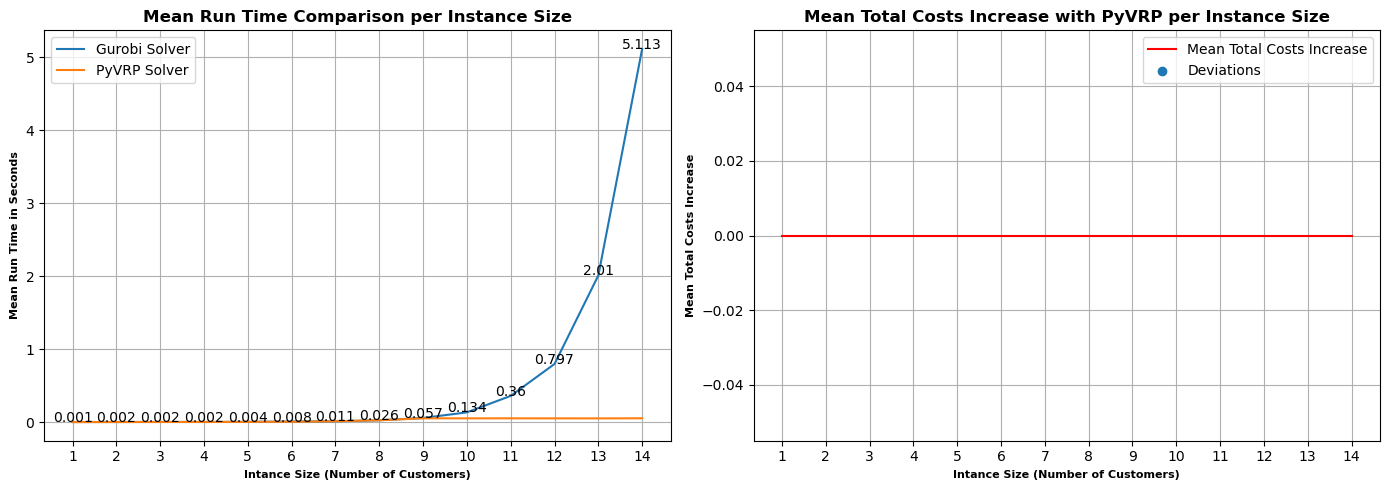

In [6]:
# Function to evaluate the solver performance
def fun_solver_accuracy(res_gurobi, res_PyVRP, num_customers_list, number_of_instances_per_size, iterations):
    # Get mean run time of both solvers
    mean_runtime_gurobi = np.mean([res_gurobi[key]['Run Times'][0] for key in res_gurobi.keys()])
    mean_runtime_PyVRP= np.mean([res_PyVRP[key]['Run Times'][0] for key in res_PyVRP.keys()])
    print('Mean Run Time of Gurobi Solver: {} sec \nMean Run Time of PyVRP Solver: {} sec'.format(np.round(mean_runtime_gurobi, 4), np.round(mean_runtime_PyVRP, 4)))
    print('Run Time improvement by: {} %'.format(np.round((1 - mean_runtime_PyVRP / mean_runtime_gurobi) * 100, 2)))

    # Get all total costs
    total_costs_gurobi = [res_gurobi[key]['Total Costs'] for key in res_gurobi.keys()]
    total_costs_PyVRP = [res_PyVRP[key]['Total Costs'] for key in res_PyVRP.keys()]

    # Compute the proportion of identical solutions
    num_identical_solutions = 0
    for index in range(len(num_customers_list)):
        num_identical_solutions += np.sum([np.round(i) == np.round(j) for i, j in zip(total_costs_gurobi[index], total_costs_PyVRP[index])]) # Use only integer values due to rounding errors
    pct_identical_solutions = np.round(num_identical_solutions / len(iterations), 4) * 100
    print('\nProportion of optimal solutions by PyVRP: {} %'.format(pct_identical_solutions))

    # Compute RMSE of the PyVRP costs compared to the optimal costs of the Gurobi solver
    a = [np.round(j) for i in total_costs_gurobi for j in i] # Put the elements in all lists in total_costs_gurobi into one list
    b = [np.round(j) for i in total_costs_PyVRP for j in i] # Use only integer values due to rounding errors
    rmse = np.sqrt(np.sum([(j-i)**2 for i, j in zip(a, b)]) / len(a)) # Equal to sklearn fct: mean_squared_error(a, b, squared=False)
    print('RMSE:', np.round(rmse, 4))
    
    # Get mean run time for all instance sizes of both solvers
    mean_cat_runtime_gurobi = {key: np.round(np.mean(res_gurobi[key]['Run Times']),4) for key in res_gurobi.keys()}
    mean_cat_runtime_PyVRP = {key: np.round(np.mean(res_PyVRP[key]['Run Times']), 4) for key in res_PyVRP.keys()}

    # Get all total costs per instance size of both solvers
    cat_costs_gurobi = {key: res_gurobi[key]['Total Costs'] for key in res_gurobi.keys()}
    cat_costs_PyVRP = {key: res_PyVRP[key]['Total Costs'] for key in res_PyVRP.keys()}
    cat_costs_differences = {}
    deviations = {}

    # Compute the deviations of all total costs and the mean per instance size
    for key in res_gurobi.keys():
        differences = [cat_costs_PyVRP[key][i] - cat_costs_gurobi[key][i] for i in range(number_of_instances_per_size)]
        differences = [0 if i < 0.5 else i for i in differences] # Remove very small differences due to rounding errors
        cat_costs_differences[key] = np.mean(differences)
        deviations[key] = [i for i in differences if i > 0]

    # Create subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    # Plot mean run times per instance size
    axs[0].plot(mean_cat_runtime_gurobi.values(), label='Gurobi Solver')
    axs[0].plot(mean_cat_runtime_PyVRP.values(), label='PyVRP Solver')
    for key, value in mean_cat_runtime_gurobi.items():
       axs[0].annotate(text=np.round(value, 3), xy=(int(key)-1, value), textcoords='offset points', xytext=(0, 0), ha='center')
    axs[0].set_xticks(ticks=range(len(mean_cat_runtime_gurobi.keys())), labels=mean_cat_runtime_gurobi.keys())
    axs[0].set_xlabel('Intance Size (Number of Customers)', size=8, fontweight='bold')
    axs[0].set_ylabel('Mean Run Time in Seconds', size=8, fontweight='bold')
    axs[0].set_title('Mean Run Time Comparison per Instance Size', size=12, fontweight='bold')
    axs[0].grid(axis='both')
    axs[0].legend()

    # Plot mean total costs deviation per instance size
    axs[1].plot(cat_costs_differences.keys(), cat_costs_differences.values(), color='r', label='Mean Total Costs Increase')
    for key in deviations.keys():
        axs[1].scatter(x=np.repeat(key, len(deviations[key])), y=deviations[key], label='Deviations' if key == list(cat_costs_differences.keys())[0] else "")
    axs[1].set_xticks(list(cat_costs_differences.keys()))
    axs[1].set_xticklabels(cat_costs_differences.keys())
    axs[1].set_xlabel('Intance Size (Number of Customers)', size=8, fontweight='bold')
    axs[1].set_ylabel('Mean Total Costs Increase', size=8, fontweight='bold')
    axs[1].set_title('Mean Total Costs Increase with PyVRP per Instance Size', size=12, fontweight='bold')
    axs[1].grid(axis='both')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    return mean_cat_runtime_gurobi, mean_cat_runtime_PyVRP

# Evaluate the solver performance
mean_cat_runtime_gurobi, mean_cat_runtime_PyVRP = fun_solver_accuracy(res_gurobi, res_PyVRP, num_customers_list, number_of_instances_per_size, iterations)

In [7]:
print(len(instances_dev))
#{number: [len(instances_dev[i]['Demands']) - 1 for i in range(len(instances_dev))].count(number) for number in num_customers_list}

display(mean_cat_runtime_gurobi)
#mean_cat_runtime_PyVRP

0


{'1': 0.0011,
 '2': 0.0015,
 '3': 0.0022,
 '4': 0.0018,
 '5': 0.004,
 '6': 0.0083,
 '7': 0.0109,
 '8': 0.0255,
 '9': 0.0569,
 '10': 0.1338,
 '11': 0.3596,
 '12': 0.7967,
 '13': 2.0096,
 '14': 5.1126}

### **CVRP**

In [8]:
# Settings
num_customers_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] # All possible instance sizes (number of customers for an instance),
number_of_instances_per_size = 100 # Determines the number of instances that are generated for each instance size (number of customers)
iterations = [(size, id) for id in np.arange(1, number_of_instances_per_size+1) for size in num_customers_list]
x_range = (0, 100)
y_range = (0, 100)
capacity_min = 10
capacity_max = 18
demand_min = 1
demand_max = 5

# Create dictionaries to store the results
res_gurobi = {size: {'Total Costs': [], 'Sequence': [], 'Run Times': []}
              for size in num_customers_list}
all_instances = pd.DataFrame()

# Only create new instances (all_instances) and recompute res_gurobi if necessary
if False:
    for num_customers, id in tqdm(iterations):
        # Generate instance and extract the X and Y coordinates of depot and all customers as well as the demands and the capacity
        instance_df = generate_cvrp_instance(num_customers, x_range, y_range, demand_min, demand_max, capacity_min, capacity_max)
        coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]
        demands = list(instance_df['Demand'])
        capacity = instance_df.loc[0, 'Vehicle Capacity']

        # Solve instance with Gurobi
        start = time.time()
        sequence, total_costs = solve_cvrp(coordinates=coord, demands=demands, capacity=capacity)
        runtime = time.time() - start
        res_gurobi[num_customers]['Total Costs'] += [np.round(total_costs, 4)]
        res_gurobi[num_customers]['Sequence'] += [sequence]
        res_gurobi[num_customers]['Run Times'] += [runtime]

        # Save instance
        instance_df['Instance ID'] = num_customers * 1000 + id
        all_instances = pd.concat([all_instances, instance_df])

    # Save all instances and the dictionary 'res_gurobi'
    all_instances.to_excel('cvrp_instances.xlsx')

    with open('cvrp_res_gurobi', 'w') as file:
        json.dump(res_gurobi, file)

100%|██████████| 1200/1200 [07:28<00:00,  2.68it/s]


Mean Run Time of Gurobi Solver: 0.9708 sec 
Mean Run Time of PyVRP Solver: 0.3665 sec
Run Time improvement by: 62.25 %

Proportion of optimal solutions by PyVRP: 92.33 %
RMSE: 53.2856


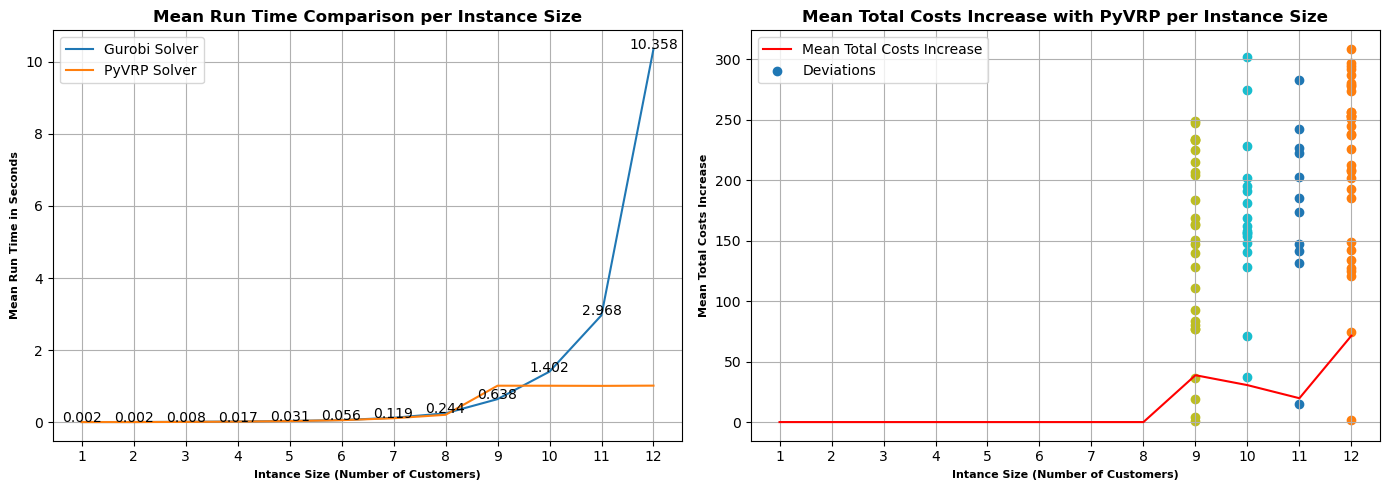

In [9]:
# Create dictionaries to store the results
res_PyVRP = {str(size): {'Total Costs': [], 'Sequence': [], 'Run Times': []} 
             for size in num_customers_list}
instances_dev = []

# Load instances and the results of the gurobi solver
all_instances = pd.read_excel('cvrp_instances.xlsx')
with open('cvrp_res_gurobi', 'r') as file:
    res_gurobi = json.load(file)

# Round results
for key in res_gurobi.keys():
    res_gurobi[key]['Total Costs'] = [np.round(i, 2) for i in res_gurobi[key]['Total Costs']]

for index, id in enumerate(tqdm(np.unique(all_instances['Instance ID']))):
    # Generate instance and extract the X and Y coordinates of depot and all customers
    instance_df = all_instances[all_instances['Instance ID'] == id].reset_index(drop=True)
    coord = [(instance_df['X'][i], instance_df['Y'][i]) for i in range(len(instance_df))]
    demands = instance_df['Demand']
    capacity = instance_df.loc[0, 'Vehicle Capacity']
    num_customers = len(instance_df) - 1 # First row is the depot

    # Use Gurobi for small instances and PyVRP solver for instances with more customers
    start = time.time()
    if (num_customers <= 8):
        sequence, total_costs = solve_cvrp(coordinates=coord, demands=demands, capacity=capacity)
    else:
        sequence, total_costs = solve_PyVRP(coord=coord, demands=demands, capacity=capacity, max_runtime=1, #0.5
                                            constant=100, plot_results=False, prints=False)
    runtime = time.time() - start
    total_costs = np.round(total_costs, 4)
    res_PyVRP[str(num_customers)]['Total Costs'] += [total_costs]
    res_PyVRP[str(num_customers)]['Run Times'] += [runtime]

    # Get the results of the Gurobi solver
    total_costs_gurobi = res_gurobi[str(num_customers)]['Total Costs'][index % number_of_instances_per_size]
    sequence_gurobi = res_gurobi[str(num_customers)]['Sequence'][index % number_of_instances_per_size]
    runtime_gurobi = res_gurobi[str(num_customers)]['Run Times'][index % number_of_instances_per_size]

    # Check wheater the solutions are the same
    test = (total_costs - total_costs_gurobi <= 0.5) # Allow very small differences due to rounding errors
    if (test == False): instances_dev.append({'Instance DF': instance_df, 'Coordinates': coord, 'Demands': demands, 'Capacity': capacity, 
                                              'Total Costs Gurobi': total_costs_gurobi, 'Sequence Gurobi': sequence_gurobi, 'Run Time Gurobi': runtime_gurobi,
                                              'Total Costs PyVRP': total_costs, 'Sequence PyVRP': sequence, 'Run Time PyVRP': runtime})

# Evaluate the solver performance
mean_cat_runtime_gurobi, mean_cat_runtime_PyVRP = fun_solver_accuracy(res_gurobi, res_PyVRP, num_customers_list, number_of_instances_per_size, iterations)

In [10]:
print(len(instances_dev))
{number: [len(instances_dev[i]['Demands']) - 1 for i in range(len(instances_dev))].count(number) for number in num_customers_list}

display(mean_cat_runtime_gurobi)
mean_cat_runtime_PyVRP

89


{'1': 0.0019,
 '2': 0.0022,
 '3': 0.0077,
 '4': 0.0166,
 '5': 0.0313,
 '6': 0.0558,
 '7': 0.1194,
 '8': 0.2439,
 '9': 0.6379,
 '10': 1.4018,
 '11': 2.9677,
 '12': 10.3583}

{'1': 0.0009,
 '2': 0.0011,
 '3': 0.0051,
 '4': 0.0127,
 '5': 0.0282,
 '6': 0.0532,
 '7': 0.107,
 '8': 0.2027,
 '9': 1.0104,
 '10': 1.0095,
 '11': 1.0058,
 '12': 1.0124}

### **View the instances with different solutions by the solvers**

483.34 - 406.15 = 77.19
Total costs: 406.15
Optimal solution: [[0, 1], [1, 7], [7, 8], [8, 5], [5, 0], [0, 3], [3, 2], [2, 6], [6, 0], [0, 4], [4, 9], [9, 0]]


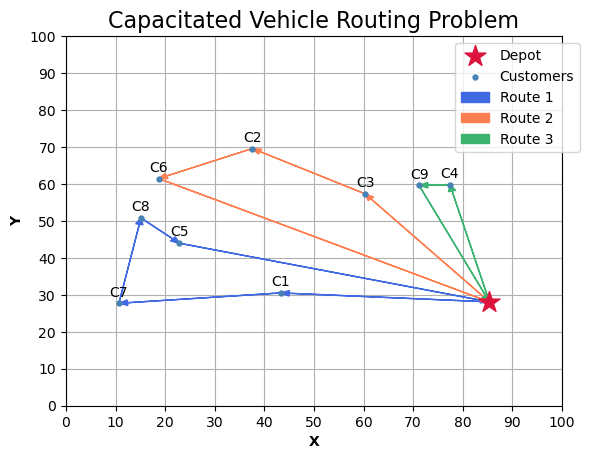

Exact Total costs: 483.3400306445237 and Rounded Total Costs: 483.34
Optimal solution: [(0, 7), (7, 5), (5, 3), (3, 0), (0, 9), (9, 2), (2, 4), (4, 0), (0, 1), (1, 6), (6, 8), (8, 0)]


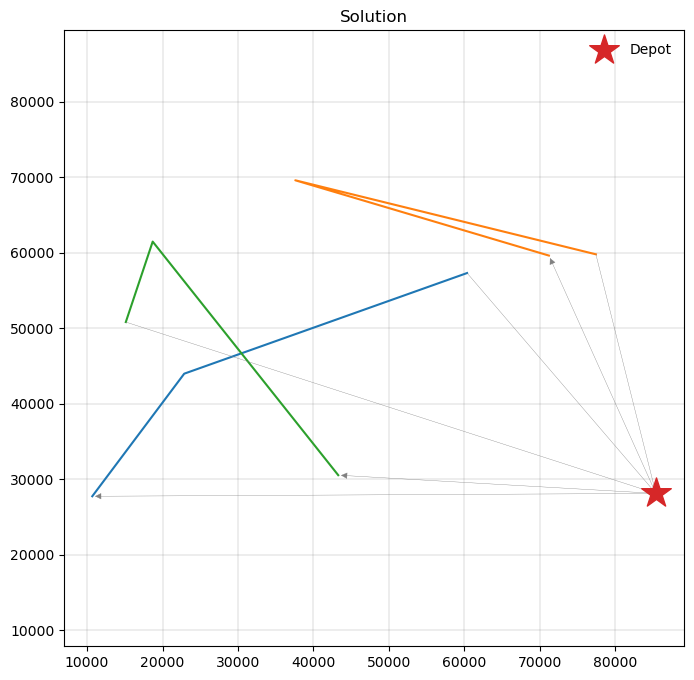

In [11]:
# Define Instance ID in list 'instances'
id = 3
c1 = instances_dev[id]['Total Costs Gurobi']
c2 = instances_dev[id]['Total Costs PyVRP']
print('{} - {} = {}'.format(c2, c1, c2-c1))

# Get instance details
coord = instances_dev[id]['Coordinates']
demands = instances_dev[id]['Demands']
capacity = instances_dev[id]['Capacity']

# Solve instance with Gurobi and plot the optimal solution
sequence = instances_dev[id]['Sequence Gurobi']
total_costs = instances_dev[id]['Total Costs Gurobi']
plot_instance(coord=coord, sequence=sequence, total_costs=total_costs, x_range=x_range, y_range=y_range, 
              assignments=None, core_point_indices=None, plot_sequence=True, print_sequence=True, routing_problem=routing_problem)

# Solve instance with PyVRP and plot the optimal solution
sequence = instances_dev[id]['Sequence PyVRP']
total_costs = instances_dev[id]['Total Costs PyVRP']
constant = 10
sequence, total_costs = solve_PyVRP(coord, demands=demands, capacity=capacity, max_runtime=0.05, 
                                    constant=1000, plot_results=True, prints=False)

In [12]:
solve_tsp(coord)
solve_cvrp(coord, demands, capacity)

([(0, 3),
  (3, 2),
  (2, 6),
  (6, 0),
  (0, 4),
  (4, 9),
  (9, 0),
  (0, 5),
  (5, 8),
  (8, 7),
  (7, 1),
  (1, 0)],
 406.15412610325103)